## Data collection

In [35]:
import os, sys, random
from numpy import mat
from pymatgen.ext.matproj import MPRester
from pymatgen.io.cif import CifParser, CifFile
import json
import csv
import subprocess
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sb

In [3]:
API_TOKEN = os.environ.get("MPTOKEN")
# print(API_TOKEN)

In [4]:
CANDIDATE_IDS = []
with open('../TMR_Data.json') as fo:
    data = json.load(fo)

for material in data['candidates']:
    CANDIDATE_IDS.append(material['material_id'])

print(CANDIDATE_IDS[:5])

['mp-1097065', 'mp-1189871', 'mp-1196573', 'mp-1245346', 'mp-1245448']


In [5]:
mpr = MPRester(API_TOKEN)

crt = {
    'material_id': {'$in': CANDIDATE_IDS},
}
prt = ['material_id', 'pretty_formula', 'icsd_ids', 'cif', 'elasticity']

cif_candidates = mpr.query(criteria=crt, properties=prt)

100%|█████████████████████████████████████████████████████████████████████████| 2236/2236 [00:14<00:00, 152.23it/s]


In [6]:
for mat in cif_candidates[:5]:
    if mat['elasticity'] is None:
        print(mat['material_id'], mat['pretty_formula'])

mp-10068 Ce2MnN3
mp-1009541 CsRbN
mp-1013531 Sr3BiN
mp-1013542 Ca3BiN


In [7]:
ID_PROPS_DATA = []
count = 1
for i in cif_candidates:
    if i['elasticity'] is not None:
        # print(f"processing {i['pretty_formula']}")
        
        ## Create CIF files from
        mat_name = f"{i['pretty_formula']}_{i['material_id']}"
        bulk_modulus = i['elasticity']['K_VRH']

        with open(f"cgcnn-mod-transformers/data/transformers-reg/{mat_name}.cif", 'w') as ff: 
            ff.write(i['cif'])
        
        ## Create csv data
        ID_PROPS_DATA.append([mat_name, bulk_modulus])
        
        # break
        count+=1

        # if count >= 20: break

with open("cgcnn-mod-transformers/data/transformers-reg/id_prop.csv", 'w', newline='') as f_csv:
    writer = csv.writer(f_csv)
    for prop in ID_PROPS_DATA:
        writer.writerow(prop)


print(count)

242


## Training

In [29]:
ROOT_DIR = os.sep.join(os.getcwd().split(os.sep)[:-1])

main_file = os.path.join(ROOT_DIR, "src/cgcnn-mod-transformers/main.py")
data_file = os.path.join(ROOT_DIR, "src/cgcnn-mod-transformers/data/transformers-reg")
python_exe = os.path.join(ROOT_DIR, "venv/Scripts/python.exe")

EPOCHS = 20
run_options = f"--train-ratio 0.6 --val-ratio 0.2 --test-ratio 0.2 --epochs {EPOCHS}"


cmd = f"python \"{main_file}\" {run_options} \"{data_file}\""
print(cmd)

result = subprocess.run(cmd, stdout=subprocess.PIPE, shell=True)
print(result.stdout.decode("utf-8"))


python "d:\Projects and Research\Python Projects\Ternary-Metal-Nitrides-Research\src/cgcnn-mod-transformers/main.py" --train-ratio 0.6 --val-ratio 0.2 --test-ratio 0.2 --epochs 20 "d:\Projects and Research\Python Projects\Ternary-Metal-Nitrides-Research\src/cgcnn-mod-transformers/data/transformers-reg"
Epoch: [0][0/1]	Time 1.014 (1.014)	Data 0.010 (0.010)	Loss 1.7364 (1.7364)	MAE 60.854 (60.854)
Test: [0/1]	Time 0.070 (0.070)	Loss 103.8634 (103.8634)	MAE 643.167 (643.167)
 * MAE 643.167
Epoch: [1][0/1]	Time 1.199 (1.199)	Data 0.017 (0.017)	Loss 6.2909 (6.2909)	MAE 148.523 (148.523)
Test: [0/1]	Time 0.209 (0.209)	Loss 135.1106 (135.1106)	MAE 734.663 (734.663)
 * MAE 734.663
Epoch: [2][0/1]	Time 1.429 (1.429)	Data 0.010 (0.010)	Loss 7.4607 (7.4607)	MAE 164.416 (164.416)
Test: [0/1]	Time 0.078 (0.078)	Loss 1.0481 (1.0481)	MAE 48.189 (48.189)
 * MAE 48.189
Epoch: [3][0/1]	Time 1.032 (1.032)	Data 0.010 (0.010)	Loss 0.6701 (0.6701)	MAE 41.435 (41.435)
Test: [0/1]	Time 0.074 (0.074)	Loss 3.98

<AxesSubplot:title={'center':'Results of a CGCNN Model predictions on the Bulk Modulus of various Ternery Metal Nitrides. [Epochs=20, TOTAL-DATASET=242, Train-Validation-Test_Ratios=6:2:2]'}, xlabel='test', ylabel='result'>

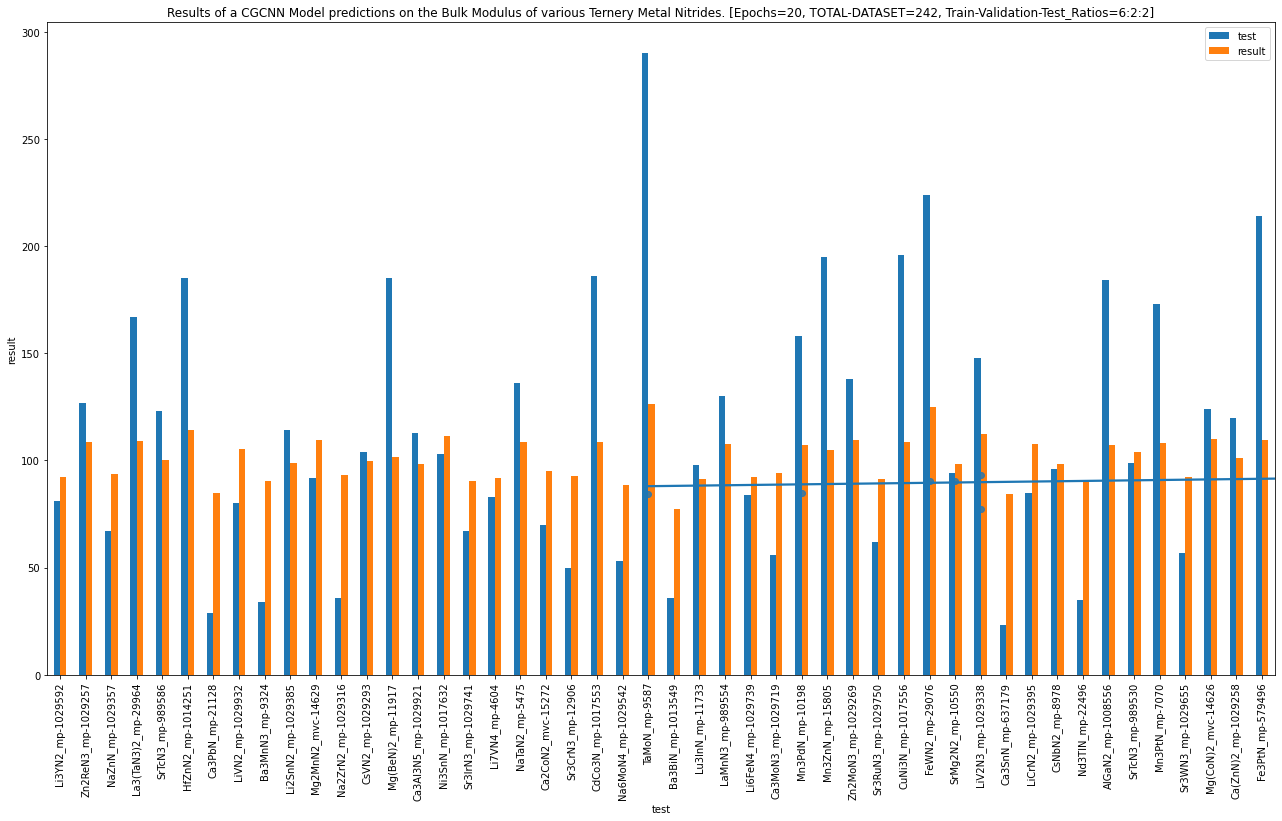

In [37]:
result_file = os.path.join(ROOT_DIR, "src/test_results.csv")

df = pd.read_csv(result_file)
df.dropna(subset=['material'], inplace=True)
df.head()
df.plot(x="material", y=["test", "result"], kind='bar', figsize=(22, 12),
        title=f"Results of a CGCNN Model predictions on the Bulk Modulus of various Ternery Metal Nitrides. [Epochs={EPOCHS}, TOTAL-DATASET={count}, Train-Validation-Test_Ratios=6:2:2]",
        sort_columns=True)


<AxesSubplot:xlabel='test', ylabel='result'>

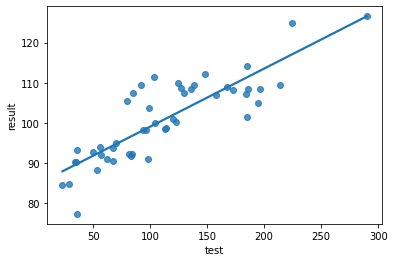

In [38]:
sb.regplot(x = "test",
            y = "result", 
            ci = None,
            data = df)